<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [ ]:
#pip install watermark
%load_ext watermark

In [ ]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

In [ ]:
!vw --version

##  1.1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta = 1e-3, n_iter = 10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_= []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0],1)),X])
        w = np.zeros(X.shape[1])
        for iteration in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                w_plus = w.copy()
                w_plus[0] += self.eta * (y[i] - w.dot(X[i,:]))
                for j in range(1, X.shape[1]):
                    w_plus[j] += self.eta * (y[i]-w.dot(X[i,:]))*X[i,j]
                w = w_plus.copy()
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))
        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self
                                        
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0],1)),X])
        return X.dot(self.w_)
     

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

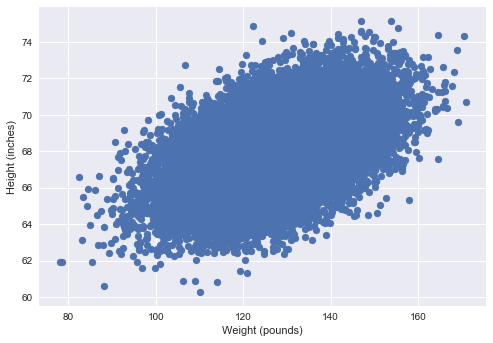

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Weight (pounds)')
plt.ylabel('Height (inches)');

In [5]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [8]:
custom_regressor = SGDRegressor()
custom_regressor.fit(X_train_scaled, y_train)

100%|██████████| 10/10 [00:33<00:00,  3.41s/it]


SGDRegressor(eta=0.001, n_iter=10)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

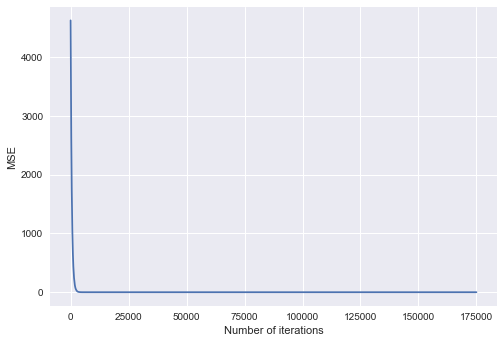

In [9]:
plt.plot(range(len(custom_regressor.mse_)),custom_regressor.mse_)
plt.xlabel('Number of iterations')
plt.ylabel('MSE')

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [13]:
print("Best weights vector is {}, giving minimal MSE = {}".format(custom_regressor.w_,min(custom_regressor.mse_)))

Best weights vector is [ 67.9898497    0.94447605], giving minimal MSE = 2.71513524066


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

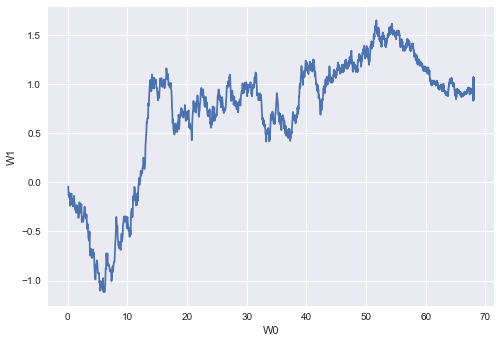

In [21]:
plt.plot([w[0] for w in custom_regressor.weights_],[w[1] for w in custom_regressor.weights_])
plt.xlabel('W0')
plt.ylabel('W1')

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [15]:
y_predict = custom_regressor.predict(X_valid_scaled)
mean_squared_error(y_valid, y_predict)

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [23]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_predict_lin = reg.predict(X_valid_scaled)
mean_squared_error(y_valid, y_predict_lin)

2.6708307676676348

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5 *right*

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$ 
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [37]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [137]:
class SGDClassifier(BaseEstimator):
    def __init__(self,eta = 1e-3, n_iter = 10, C = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.C = C
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0],1)),X])
        w = np.zeros((X.shape[1]))
        for iteration in tqdm(range(self.n_iter)):
            
            for i in range(X.shape[0]):
                
                w_plus = w.copy()
                w_plus[0]+=self.eta * self.C * sigma(-y[i]*w.dot(X[i,:])) * y[i]
                for j in range(1,X.shape[1]):
                    w_plus[j] += self.eta * (self.C * y[i] * sigma(-y[i]*w.dot(X[i,:])) * X[i,j] - w[j])
                w = w_plus.copy()
                                
                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                self.weights_.append(w)
    
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
  
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0],1)),X])
        p_plus = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1-p_plus,p_plus])
    
    def predict(self, X):
        p_plus = self.predict_proba(X)[:,1]
        signs = np.sign(p_plus - 0.5)
        signs[np.where(signs == 0)] = 1
        return signs
   

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [29]:
from sklearn.datasets import load_breast_cancer

In [30]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [102]:
custom_clf = SGDClassifier(C = 1, eta = 1e-3, n_iter = 3)
custom_clf.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

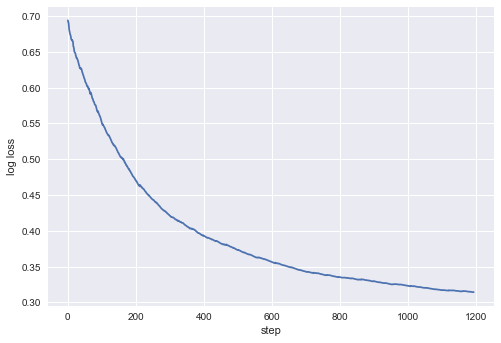

In [103]:
plt.plot(custom_clf.loss_)
plt.xlabel('step')
plt.ylabel('log loss')

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [138]:
custom_clf2 = SGDClassifier(C = 1000, eta = 1e-3, n_iter = 10)
custom_clf2.fit(X_train_scaled, y_train)

100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


SGDClassifier(C=1000, eta=0.001, n_iter=10)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

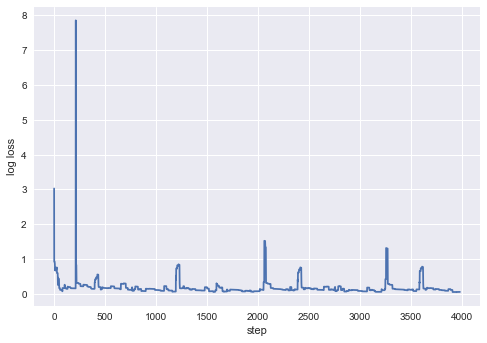

In [139]:
plt.plot(custom_clf2.loss_)
plt.xlabel('step')
plt.ylabel('log loss')

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity *correct*
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension 

In [134]:
weights = custom_clf2.w_[1:]
cancer.feature_names[np.argmin(weights)]

'worst concavity'

In [76]:
feature_importance = pd.DataFrame({'coef': weights,
             'feat': list(cancer.feature_names)}).sort_values(by='coef')
feature_importance.head()

,coef,feat
26,-5.107343,worst concavity
10,-4.531819,radius error
21,-4.051564,worst texture
6,-3.566910,mean concavity
7,-3.543276,mean concave points


Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [147]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 17)
clf.fit(X_train_scaled, y_train)
print('The most important feature for out-of-box logistic regression: "{}"'.format(
    cancer.feature_names[np.argmin(clf.coef_.flatten())]))
logreg_logloss = log_loss(y_valid, clf.predict(X_valid_scaled))
logreg_rocauc = roc_auc_score(y_valid, clf.predict(X_valid_scaled))

The most important feature for out-of-box logistic regression: "radius error"


In [148]:
# calculate logloss and roc_auc for actual +1/-1 prediction
y_predict_custom = custom_clf2.predict(X_valid_scaled)
custom_logloss = log_loss(y_valid, y_predict_custom)
custom_rocauc = roc_auc_score(y_valid, y_predict_custom)
print('Log loss in unoptimized regression {} vs custom SGD {}'.format(custom_logloss,logreg_logloss))
print('ROC_AUC in unoptimized regression {} vs custom SGD {}'.format(custom_rocauc,logreg_rocauc))

Log loss in unoptimized regression 1.00992912258 vs custom SGD 0.807943298066
ROC_AUC in unoptimized regression 0.959016393443 vs custom SGD 0.967213114754


In [149]:
# calculate logloss and roc_auc for p_plus
logreg_logloss = log_loss(y_valid, clf.predict_proba(X_valid_scaled)[:,1])
logreg_rocauc = roc_auc_score(y_valid, clf.predict_proba(X_valid_scaled)[:,1])
y_predict_custom = custom_clf2.predict_proba(X_valid_scaled)[:,1]
custom_logloss = log_loss(y_valid, y_predict_custom)
custom_rocauc = roc_auc_score(y_valid, y_predict_custom)
print('Log loss in unoptimized regression {} vs custom SGD {}'.format(custom_logloss,logreg_logloss))
print('ROC_AUC in unoptimized regression {} vs custom SGD {}'.format(custom_rocauc,logreg_rocauc))

Log loss in unoptimized regression 0.434411079396 vs custom SGD 0.105692134779
ROC_AUC in unoptimized regression 0.976304023845 vs custom SGD 0.989269746647


## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [150]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [151]:
reviews_train = load_files("/Users/i_yu_b/Dropbox/DS/ML Habr/mlcourse_open/data/imdb_reviews/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [152]:
reviews_test = load_files("/Users/i_yu_b/Dropbox/DS/ML Habr/mlcourse_open/data/imdb_reviews/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [153]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 39.7 s, sys: 1.61 s, total: 41.3 s
Wall time: 42.2 s


In [154]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [157]:
%%time
logit = LogisticRegression(random_state = 17)
logit.fit(X_train, y_train)

CPU times: user 36.7 s, sys: 307 ms, total: 37 s
Wall time: 37.2 s


In [158]:
roc_score_logit = roc_auc_score(y_test,logit.predict(X_test))
print('ROC AUC score {}'.format(roc_score_logit))

ROC AUC score 0.89628


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска *correct*
 - Реализован линейный SVM *correct*
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам *correct*
 - Можно обучать LASSO *correct*
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектам сразу, а не по одному) *correct*


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [161]:
%%time
sgdc = SGDClassifier(loss='log', alpha=0.0001, n_iter=100, n_jobs=-1, random_state=17)
sgdc.fit(X_train, y_train)

CPU times: user 6.5 s, sys: 299 ms, total: 6.8 s
Wall time: 7.03 s


In [162]:
roc_score_logit = roc_auc_score(y_test,sgdc.predict(X_test))
print('ROC AUC score {}'.format(roc_score_logit))

ROC AUC score 0.8942


<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3 *correct*
 - 4
 - 5